In [ ]:
import numpy as np

from dask.delayed import delayed
from dask.base import compute
from dask.diagnostics.progress import ProgressBar

from symbolic_regression.methods.gp import GP
from symbolic_regression.methods.gpshap import GPSHAP
from symbolic_regression.methods.gpcmi import GPCMI

from symbolic_regression.utils.pysr_utils import nrmse_loss, train_val_test_split
from symbolic_regression.datasets import load_datasets

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

sns.set_theme()
warnings.filterwarnings("ignore", category=UserWarning, module="pysr")
warnings.filterwarnings("ignore", category=RuntimeWarning)

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
n_runs = 2
test_size = 0.2
val_size = 0.25
n_top_features = None
k = 5
ci = 0.99
record_interval = 5

pysr_params = {
    "populations": 1,
    "population_size": 20,
    "niterations": 20,
    "binary_operators": ["+", "-", "*"],
    "unary_operators": ["sqrt", "inv(x) = 1/x"],
    "extra_sympy_mappings": {"inv": lambda x: 1/x},
    "verbosity": 0,
}

dataset_names = [
    "F1",
    # "F2",
    # ("4544_GeographicalOriginalofMusic", "4544_GOM"),
    # "505_tecator",
    # ("Communities and Crime", "CCN"),
    # ("Communities and Crime Unnormalized", "CCUN"),
]

datasets = load_datasets(dataset_names)
datasets.keys()

dict_keys(['F1'])

In [3]:
gp_params = {
    "loss_function": nrmse_loss,
    "record_interval": record_interval,
    **pysr_params,
}

gpshap_params = {**gp_params}

gpcmi_params = {
    **gp_params,
    "k": k,
    "ci": ci
}

shap_params = {
    "test_size": test_size,
    "val_size": val_size,
    "n_runs": n_runs,
    "n_top_features": n_top_features,
    **gp_params
}

In [4]:
gp = GP(**gp_params)
gpshap = GPSHAP(**gpshap_params)
gpcmi = GPCMI(**gpcmi_params)

methods = {
    "GP": gp,
    "GPSHAP": gpshap,
    "GPCMI": gpcmi
}

width_method = max([round(len(name), 0) for name in methods.keys()])
width_dataset = max([round(len(name), 0) for name in datasets.keys()])

n_records = methods[list(methods.keys())[0]].n_records
n_records

4

In [5]:
results = {}
equations = {}
features = {}
if "GPSHAP" in methods:
    methods["GPSHAP"].clear_cache()  # Clear cache before starting new tasks

for dataset_name, dataset in datasets.items():
    results[dataset_name] = {}
    equations[dataset_name] = {}
    features[dataset_name] = {}
    train_val_test_sets = []

    X = dataset["X"]
    y = dataset["y"]

    for _ in range(n_runs):
        train_val_test_set = train_val_test_split(X, y)
        train_val_test_sets.append(train_val_test_set)

    for method_name, method in methods.items():
        results[dataset_name][method_name] = {
            "training_losses": np.empty((n_runs, n_records)),
            "validation_losses": np.empty((n_runs, n_records)),
            "test_losses": np.empty((n_runs, n_records)),
        }
        equations[dataset_name][method_name] = []
        features[dataset_name][method_name] = []

        print(f"Running {method_name:<{width_method}} on {dataset_name:<{width_dataset}} ", end="")

        if (method_name == "GPSHAP"):
            if equations[dataset_name].get('GP', False):
                X_trains = tuple([train_val_test_set[0] for train_val_test_set in train_val_test_sets])
                gp_equations = [eqs[-1] for eqs in equations[dataset_name]['GP']]
                
                method.precompute_features_from_pretrained_models(X_trains, gp_equations, n_top_features)
            
            else: method.precompute_features(X, y, **shap_params)

        for run in range(n_runs):
            print(".", end="")

            temp_losses, temp_best_eqs, temp_features = method.run(
                train_val_test_sets[run]
            )

            results[dataset_name][method_name]["training_losses"][run, :] = temp_losses[0]
            results[dataset_name][method_name]["validation_losses"][run, :] = temp_losses[1]
            results[dataset_name][method_name]["test_losses"][run, :] = temp_losses[2]
            equations[dataset_name][method_name].append(temp_best_eqs)
            features[dataset_name][method_name].append(temp_features)

        print("Done")

Running GP     on F1 ..Done
Running GPSHAP on F1 ..Done
Running GPCMI  on F1 ..Done


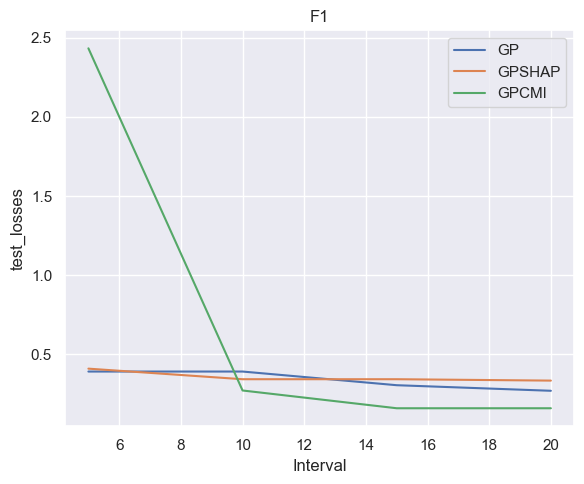

In [6]:
# metrics = 'training_losses'
# metrics = 'validation_losses'
metrics = 'test_losses'
n_datasets = len(results)
# record_interval = gp_params['record_interval']
fig, axes = plt.subplots(1, n_datasets, figsize=(6 * n_datasets, 5))

if n_datasets == 1:
    axes = [axes]  # Ensure axes is always iterable

for ax, (dataset_name, dataset_results) in zip(axes, results.items()):
    # Get the number of intervals from any method (they should all be the same)
    method = next(iter(dataset_results))
    length = len(dataset_results[method][metrics].mean(axis=0))


    for method in dataset_results.keys():
        ax.plot(
            range(record_interval, length * record_interval + 1, record_interval),
            np.mean(dataset_results[method][metrics], axis=0),
            # dataset_results[method][metrics],
            label=method
        )
    ax.set_title(dataset_name)
    ax.set_xlabel("Interval")
    # ax.set_yscale("log")
    ax.legend()

axes[0].set_ylabel(metrics)
plt.tight_layout()

plt.show()

In [7]:
# NOTE: The following code is for parallel processing of tasks across datasets and methods.

@delayed
def process_task(dataset_name, method_name, run, train_val_test_set, method, _=None):
    temp_losses, temp_best_eqs, temp_features = method.run(train_val_test_set)

    return {
        'dataset_name': dataset_name,
        'method_name': method_name,
        'run': run,
        'losses': temp_losses,
        'equations': temp_best_eqs,
        'features': temp_features
    }

delayed_tasks = {}
if "GPSHAP" in methods:
    methods["GPSHAP"].clear_cache()  # Clear cache before starting new task

for dataset_name, dataset in datasets.items():
    delayed_tasks[dataset_name] = {}

    X = dataset["X"]
    y = dataset["y"]

    delayed_splits = [delayed(train_val_test_split)(X, y) for _ in range(n_runs)]
    
    for method_name, method in methods.items():
        delayed_tasks[dataset_name][method_name] = []

        if method_name == "GPSHAP": continue  # Skip GPSHAP for now, as it requires precomputed features

        # Create a delayed task for each method and dataset
        for run in range(n_runs):
            delayed_tasks[dataset_name][method_name].append(
                process_task(dataset_name, method_name, run, delayed_splits[run], method)
            )
    
    if ("GPSHAP" in methods):
        if ('GP' in methods):
            delayed_X_trains = tuple([delayed_split[0] for delayed_split in delayed_splits])
            delayed_gp_equations = [delayed_task['equations'][-1] for delayed_task in delayed_tasks[dataset_name]["GP"]]
            
            # Use GP's equations for GPSHAP
            delayed_precomputed_features_task = delayed(methods["GPSHAP"].precompute_features_from_pretrained_models)(
                delayed_X_trains, delayed_gp_equations, n_top_features
            )

        else:
            delayed_precomputed_features_task = delayed(methods["GPSHAP"].precompute_features)(
                X, y, **shap_params
            )

        for run in range(n_runs):
            delayed_tasks[dataset_name]["GPSHAP"].append(
                process_task(dataset_name, 'GPSHAP', run, delayed_splits[run], methods["GPSHAP"], delayed_precomputed_features_task)
            )

tasks_to_run = [
    task 
    for methods_dict in delayed_tasks.values() 
    for task_list in methods_dict.values() 
    for task in task_list
]

with ProgressBar():
    computed_results = compute(*tasks_to_run, scheduler='processes')

results = {}
equations = {}
features = {}

for dataset_name in datasets.keys():
    results[dataset_name] = {}
    equations[dataset_name] = {}
    features[dataset_name] = {}

    for method_name in methods.keys():
        results[dataset_name][method_name] = {
            "training_losses": np.empty((n_runs, n_records)),
            "validation_losses": np.empty((n_runs, n_records)),
            "test_losses": np.empty((n_runs, n_records)),
        }
        equations[dataset_name][method_name] = []
        features[dataset_name][method_name] = []

for result in computed_results:
    dataset_name = result['dataset_name']
    method_name = result['method_name']
    run = result['run']
    
    results[dataset_name][method_name]["training_losses"][run, :] = result['losses'][0]
    results[dataset_name][method_name]["validation_losses"][run, :] = result['losses'][1]
    results[dataset_name][method_name]["test_losses"][run, :] = result['losses'][2]
    
    equations[dataset_name][method_name].append(result['equations'])
    features[dataset_name][method_name].append(result['features'])

[########################################] | 100% Completed | 47.50 s


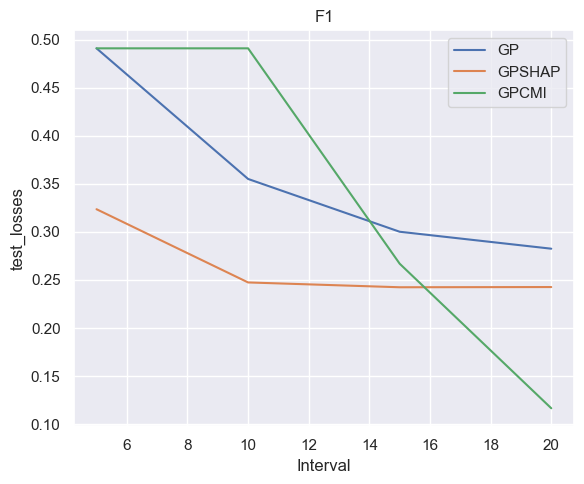

In [8]:
# metrics = 'training_losses'
# metrics = 'validation_losses'
metrics = 'test_losses'
n_datasets = len(results)
# record_interval = gp_params['record_interval']
fig, axes = plt.subplots(1, n_datasets, figsize=(6 * n_datasets, 5))

if n_datasets == 1:
    axes = [axes]  # Ensure axes is always iterable

for ax, (dataset_name, dataset_results) in zip(axes, results.items()):
    # Get the number of intervals from any method (they should all be the same)
    method = next(iter(dataset_results))
    length = len(dataset_results[method][metrics].mean(axis=0))


    for method in dataset_results.keys():
        ax.plot(
            range(record_interval, length * record_interval + 1, record_interval),
            np.mean(dataset_results[method][metrics], axis=0),
            # dataset_results[method][metrics],
            label=method
        )
    ax.set_title(dataset_name)
    ax.set_xlabel("Interval")
    # ax.set_yscale("log")
    ax.legend()

axes[0].set_ylabel(metrics)
plt.tight_layout()

plt.show()

In [9]:
features['F1']['GPCMI']

[['X2', 'X1', 'X3'], ['X2', 'X1', 'X3']]

In [10]:
features['F1']['GPSHAP'][0]

['noise_40', 'X2']

In [11]:
    # Create a new data split with only the selected features
#     train_val_test_set_filtered = (
#     X_train[selected_features],
#     X_val[selected_features],
#     X_test[selected_features],
#     y_train,
#     y_val,
#     y_test,
# )

# features = train_val_test_set_filtered[0].columns.tolist()

# training_losses, validation_losses, test_losses, best_eqs = fit_and_evaluate_best_equation(
#     train_val_test_set_filtered,
#     self.loss_function,
#     self.record_interval,
#     self.pysr_params
# )

# return (training_losses, validation_losses, test_losses), best_eqs, features